# extracting features from images of the sun

In this notebook, we will extract features from images taken by the Atmospheric Imaging Assembly (AIA) instrument on NASA's Solar Dynamics Observatory (SDO) satellite by co-aligning them with the Helioseismic and Magnetic Imager (HMI) instrument's HMI Active Region Patch (HARP) data. The AIA instrument takes images of the Sun's atmosphere, or corona, in ultraviolet light; the HMI instrument takes images of the Sun's photosphere, or surface, in optical light. <br>

During solar flares, the Sun's corona gets particularly bright. Here's a video of one of the largest flares that erupted over the last five years:

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("4xKRBkBBEP0", start=9)

We still do not fully understand why a solar flare releases so much energy so fast, and what, exactly, the magnetic topology of the corona looks like during a flare. One commonly, though not universally, accepted theory is that ropes of magnetic field, called flux ropes, hang out in the chromosphere, or the layer between the solar surface and corona. These ropes twist up and release energy during a flare. If that's true, we should look at the chromosphere for clues. Let's grab an image showing a patch of the chromosphere where the flare takes place. First, let's import some modules:

In [2]:
import json, urllib, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick
import sunpy.map
from astropy.io import fits
from datetime import datetime as dt_obj
import matplotlib.dates as mdates
import matplotlib.colors as mcol
import matplotlib.patches as ptc
from matplotlib.dates import *
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now, let's query the JSOC database, where all the SDO data are stored, using the JSON API to retrieve both keywords and the location of the image files. The [astropy](http://docs.astropy.org/en/stable/io/fits/index.html) library's  `fits.open()` call downloads the data.

In [3]:
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=aia.lev1[2012.03.06_23:29:06_TAI/12s][?WAVELNTH=1600?]&op=rs_list&key=T_REC,CROTA2,CDELT1&seg=image_lev1"
response = urllib.urlopen(url)
data = json.loads(response.read())
keywords = data['keywords'][0]['values']
filename = data['segments'][0]['values'][0]
url = "http://jsoc.stanford.edu"+filename           
chromosphere_image = fits.open(url) 

We queried for a few keywords. `T_REC` indicates the time the image was taken (technically the mid-point of the integration time). `CROTA2` indicates the rotation of the camera with respect to the fixed Sun in degrees. `CDELT1` indicates the platescale of the instrument, in the x-direction, in arseconds per pixel. We'll need these keywords later to coalign these data with others.

In [4]:
T_REC = data['keywords'][0]['values'][0]
CROTA2_AIA = float(data['keywords'][1]['values'][0])
CDELT1_AIA = float(data['keywords'][2]['values'][0])

Here's an image of the chromosphere for the same flare as the YouTube video above. The [SunPy](http://docs.sunpy.org/en/stable/guide/plotting.html#peek) library's `peek()` function allows us to look at the data in the standard AIA color tables without much effort at all:

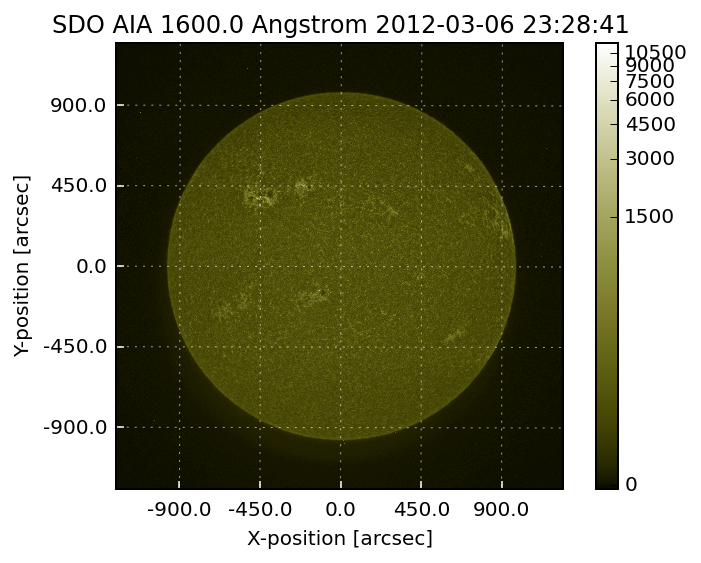

In [5]:
sunpy.map.Map(url).peek()

The Helioseismic and Magnetic Imager (HMI), another instrument aboard SDO, takes images of the solar surface, or photosphere. Here's an image of the photosphere taken at the same time as the chromospheric image above. You can see that it is rotated 180 degrees with respect to the AIA image, which is why it is important for us to take the `CROTA2` value for each instrument into consideration when doing any array manipulation.

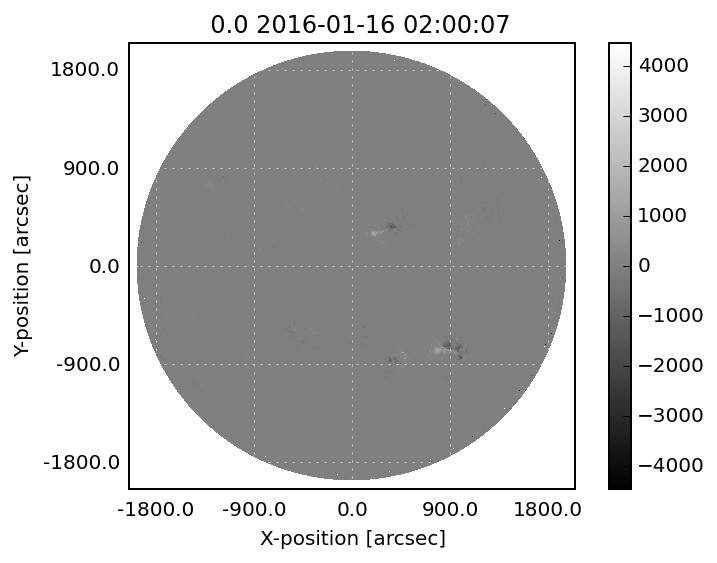

In [6]:
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.M_720s[2012.03.06_23:29:06_TAI]&op=rs_list&seg=magnetogram"
response = urllib.urlopen(url)
data = json.loads(response.read())
filename = data['segments'][0]['values'][0]
url = "http://jsoc.stanford.edu"+filename
photosphere_full_image = fits.open(url)   # download the data
sunpy.map.Map(url).peek()                 # peek at the data

The images above are 4096x4096 pixels, but binned down significantly. Let's zoom in on the active region. There's a particular type of SDO data called HMI Active Region Patches, or HARPs. These are smaller-sized arrays, zoomed in on automatically-detected active regions. This is what these patches look like for our selected `T_REC`:

In [7]:
from IPython.display import Image
Image(url="http://jsoc.stanford.edu/doc/data/hmi/harp/harp_definitive/2012/03/06/harp.2012.03.06_23:00:00_TAI.png")

Let's query for HARP number 1449 at this `T_REC` in CCD coordinates:

In [8]:
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s[1449][2012.03.06_23:29:06_TAI]&op=rs_list&key=CRPIX1,CRPIX2,CROTA2,CDELT1&seg=magnetogram"
response = urllib.urlopen(url)
data = json.loads(response.read())
filename = data['segments'][0]['values'][0]
url = "http://jsoc.stanford.edu"+filename
photosphere_image = fits.open(url)        # download the data

In addition to downloading the patch data, we also need some metadata. `CRPIX1` gives the location, in pixels, of the x-coordinate of disk center with respect to the lower left-hand corner of the patch. `CRPIX2` does the same with the y-coordinate. `XDIM` and `YDIM` give the x and y-dimensions of the image, respectively, in pixels.

In [9]:
keywords = data['keywords'][0]['values']
CRPIX1 = float(data['keywords'][0]['values'][0])
CRPIX2 = float(data['keywords'][1]['values'][0])
CROTA2_HMI = float(data['keywords'][2]['values'][0])
CDELT1_HMI = float(data['keywords'][3]['values'][0])
XDIM = float(data['segments'][0]['dims'][0].rsplit('x', 1)[0])
YDIM = float(data['segments'][0]['dims'][0].rsplit('x', 1)[1])

Then we must make sure that the angle between the HMI camera and the fixed Sun is approximately zero; otherwise, we'll rotate the image to ensure this is so. 

In [10]:
if (CROTA2_HMI > 5.0):
    print "The HMI camera rotation angle is",CROTA2_HMI,". Rotating HMI images."
    photosphere_full_image[1].data = np.rot90(photosphere_full_image[1].data,2)
    photosphere_image[1].data = np.rot90(photosphere_image[1].data,2)

The HMI camera rotation angle is 180.082581 . Rotating HMI images.


Now we can plot HARP number 1449 at this `T_REC` in CCD coordinates:

The dimensions of this image are 480 by 1056 .


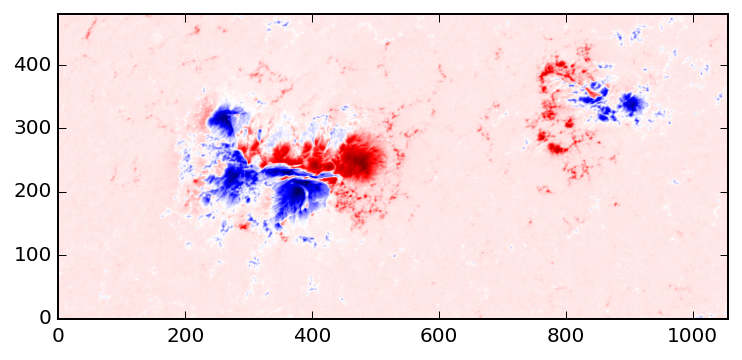

In [11]:
plt.imshow(photosphere_image[1].data,cmap='seismic',origin='lower',extent=[0,XDIM,0,YDIM])
print 'The dimensions of this image are',photosphere_image[1].data.shape[0],'by',photosphere_image[1].data.shape[1],'.'

We can also identify this area on the full-disk image in CCD coordinates:

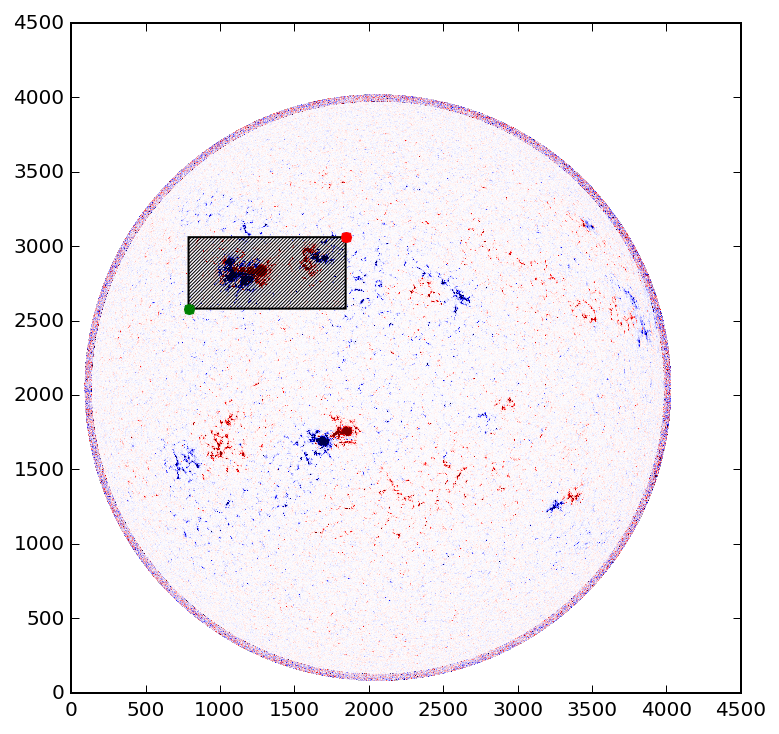

In [12]:
fig, ax = plt.subplots(1,1)
plt.imshow(photosphere_full_image[1].data,cmap='seismic',origin='lower',vmax=300,vmin=-300,extent=[0,4096,0,4096])
y1 = (2048. + CRPIX2 - YDIM)  
y2 = (2048. + CRPIX2)
x1 = (2048. + CRPIX1 - XDIM)
x2 = (2048. + CRPIX1)

# draw a box using matplotlib.patches.Rectangle
ax.add_patch(ptc.Rectangle((x1, y1), XDIM, YDIM, hatch='///////', fill=False, snap=False))

# plot a green dot at the lower left-hand corner
plt.plot(x1, y1, 'g.', markersize=10.0)

# plot a red dot at the upper right-hand corner
plt.plot(x2, y2, 'r.', markersize=10.0)
fig.set_size_inches(6,6)

If we are interested in cutting an HARP-sized box out of AIA data, the first thing we can do is compute the ratio of the platescales. Since HMI and AIA are not observing in the same wavelength, the radius of the solar disk is different in both images and, as a result, the platescale is too:

In [13]:
ratio = (CDELT1_HMI)/(CDELT1_AIA)
print "The ratio of the HMI:AIA platescales is",ratio

The ratio of the HMI:AIA platescales is 0.827557177624


Now we can cut the same sized array out of the AIA data. We first have to use the astropy package to fix the FITS header as some of the AIA keywords have non-standard values. Then we must again make sure that the angle between the camera and the fixed Sun is approximately zero; otherwise, we'll rotate the image to ensure this is so. 

In [14]:
chromosphere_image.verify("fix")
if (CROTA2_AIA > 5.0):
    print "The AIA camera rotation angle is",CROTA2_AIA,". Rotating AIA image."
    chromosphere_image[1].data = np.rot90(chromosphere_image[1].data,2)
subdata = chromosphere_image[1].data[(2048. + CRPIX2*(ratio) - YDIM*(ratio)) : (2048. + CRPIX2*(ratio)),(2048. + CRPIX1*(ratio) - XDIM*(ratio)) : (2048. + CRPIX1*(ratio))]

Now we can look at the patch of chromospheric data taken by the AIA instrument. Though it is not easy to see, the twisted S-shape feature may be the signature of a flux rope.

The dimensions of this image are 397 by 874 .


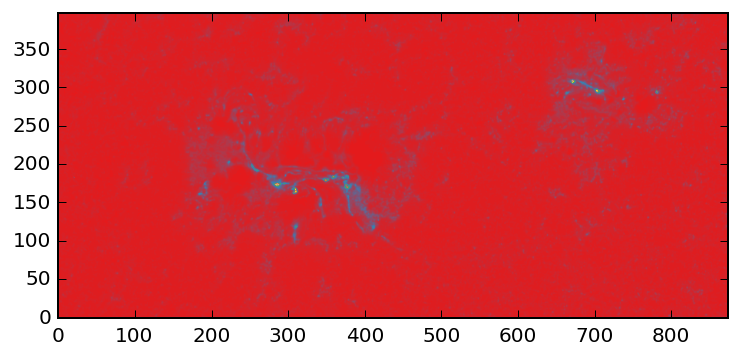

In [15]:
plt.imshow(subdata,cmap='Set1',origin='lower')
print 'The dimensions of this image are',subdata.shape[0],'by',subdata.shape[1],'.'

You can see the chromospheric patch is a bit smaller, in both latitudinal and longitudinal extent, from the photospheric data taken by the HMI instrument. This is, again, exactly what we expect since the solar radius is a bit smaller in the ultraviolet wavelengths taken by AIA versus the optical wavelengths observed by HMI. Now we can create a simple intensity threshold on the chromospheric data, which better reveals the S-shape structure:

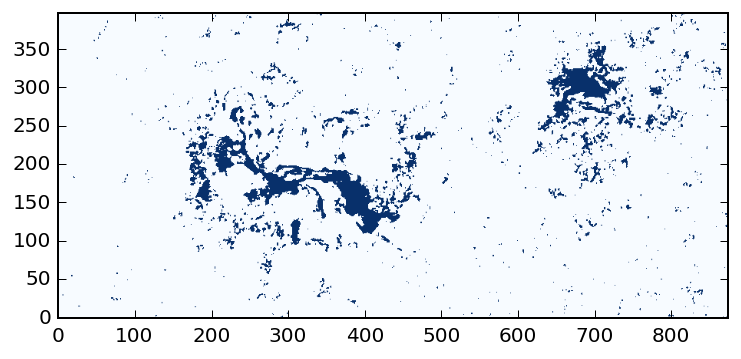

In [16]:
threshold = subdata > ((np.mean(subdata))*2.0)
plt.imshow(threshold,cmap='Blues',origin='lower')

Now we can create a new parameter, by summing up all of the pixels in the thresholded image:

In [17]:
print np.sum(subdata[threshold])

12535206


This parameter may be useful in predicting solar flares as it isolates the S-shape, which appears quite intense in the chromospheric data. Presumably, chromospheric data without an S-shape would have low values for this feature, whereas chromospheric data with an S-shape would have high values. As such, we can use a simple analysis like this to test if the presence of a flux rope is really associated with flaring active regions, assuming we've isolated it properly and that we accept that it is a flux rope in the first place. The Solar Dynamics Observatory's feature-finding team isolated S-shaped, or sigmoidal structures, in the data, as well as a host of other features known to be associated with solar flares. [Check out their results](http://link.springer.com/article/10.1007%2Fs11207-010-9697-y).